
# Imputing Missing Values

## Description

Proper handling of missing data is crucial to deriving reliable conclusions from an analysis, particularly when the underlying process is not completely random. The following three examples illustrate these critical cases:

* A survey-based earnings series may have missing values because high-income respondents do not want to reveal their earnings. 
* Patients may be more likely to opt out of undertaking a medical treatment when the treatment causes discomfort. 
* A blood pressure data series may have missing values for young patients who have no cardiovascular diseases. 

This analysis focuses on one of these critical cases illustrated by the blood pressure example above. This case is called "missingness at random", a confusing name as it does not sound much different from the "missingness completely at random" case. But, they are different. When data are missing at random, the probability of missingness depends on the available information. The following analysis examines if a random regression approach can be used to impute the missing data in these cases (for a comprehensive treatment of the subject, please refer to Gelman and Hill).  

The analysis uses an unconditional income convergence model for its simplicity. In this model, growth in a country's incomes is explained by the country's initial income level, adjusted for cross-country price differentials. The expectation is that countries that start off from a relatively low income level grow faster and catch up with the rest. The "missingness at random" mechanism is implemented by setting half of the values in the independent variable, PPP adjusted per capita GDP series, to missing .

## Data Preparation



The data used in the analysis are from the World Development Indicators database, downloaded through the API. To limit the analysis the countries and exclude the aggregates, the UN country code list is used as a filter.

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.stats import gmean
import numpy as np

In [2]:
url = 'http://api.worldbank.org/v2/country/all/indicator'
indicator_list = ['NY.GDP.PCAP.KD.ZG',
                  'NY.GDP.PCAP.PP.CD']
parameters = {'date': '1989:2018',
              'footnote': 'n',
              'format': 'json',
              'per_page': 7920}
results_list = []
for indicator in indicator_list:
    results = requests.get(f'{url}/{indicator}', params = parameters)
    if results.status_code == 200:
        results_list.append(results.json())
    else:
        print('Failed request')

In [3]:
%run data_prep.py

In [41]:
df = flatten_wb_api_response(results_list)

In [ ]:
df = clean_df(df)

The initial per capita GDP (PPP adjusted) is a 3-year (1994-96) average.

In [75]:
df.head()

indicator,country_iso3_code,country,year,pc_GDP_growth,pc_GDP_PPP
5,ABW,Aruba,1994,2.284430,27714.716606
6,ABW,Aruba,1995,-2.079505,27707.433894
7,ABW,Aruba,1996,-2.311930,27562.459828
8,ABW,Aruba,1997,4.226981,29222.894599
9,ABW,Aruba,1998,-0.141877,29509.877023


In [77]:
pc_GDP_PPP_df = df.loc[(df.year >= 1994) & (df.year <= 1996)]
pc_GDP_PPP_df = pc_GDP_PPP_df.groupby(['country_iso3_code', 'country']).mean()[['pc_GDP_PPP']]

Geometric average of the real GDP growth rates is computed for each country and for the period 1995-2018.

In [139]:
pc_GDP_growth_df = df.loc[(df.year >= 1995) & (df.year <= 2018)]

In [140]:
pc_GDP_growth_df['pc_GDP_growth'] = (pc_GDP_growth_df.pc_GDP_growth + 100) / 100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
pc_GDP_growth_df = pc_GDP_growth_df.groupby(['country_iso3_code', 'country'])

In [142]:
pc_GDP_growth_df = pc_GDP_growth_df.pc_GDP_growth.apply(gmean)

In [160]:
convergence_df = pc_GDP_PPP_df.merge(pc_GDP_growth_df, left_index = True, right_index = True)

In [161]:
convergence_df['pc_GDP_PPP'] = np.log(convergence_df.pc_GDP_PPP)

In [149]:
convergence_df.head()

,,pc_GDP_PPP,pc_GDP_growth
country_iso3_code,country,,
ABW,Aruba,10.227798,0.995324
AGO,Angola,7.878085,1.026443
ALB,Albania,7.880279,1.052317
ARE,United Arab Emirates,11.401524,0.982802
ARG,Argentina,9.234410,1.009583


## Analysis

In [162]:
convergence_df['weight'] = convergence_df.pc_GDP_growth / convergence_df.pc_GDP_growth.sum()

(0.005, 0.007)

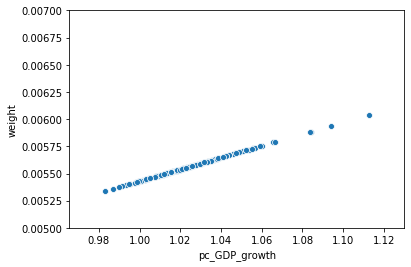

In [163]:
ax1 = sns.scatterplot(x = 'pc_GDP_growth', y = 'weight', data = convergence_df)
ax1.set_ylim([0.005, 0.007])

In [164]:
convergence_df.weight.sum()

1.0